## Setting up
- Notebook: `Adagrad(model.parameters(), lr=0.01, eps=1e-8)` 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/"My Drive"/"Data Colab"/oml-project

/content/drive/My Drive/Data Colab/oml-project


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
from tqdm import tqdm

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
# hyperparameters
BATCH_SIZE = 64

In [ ]:
train_set = torchvision.datasets.CIFAR10('./data', download=True, train=True, transform=transforms.Compose([transforms.ToTensor()]))

Files already downloaded and verified


In [ ]:
test_set = torchvision.datasets.CIFAR10("./data", download=True, train=False, transform=transforms.Compose([transforms.ToTensor()])) 

Files already downloaded and verified


In [ ]:
# sampling for smaller dataset: train
TRAIN_SAMPLES = int(len(train_set) / (10 * 2))
train_class_seen = dict([(i, 0) for i in range(10)])
train_indices = []
for i, (_, l) in enumerate(train_set):
  if train_class_seen[l] >= TRAIN_SAMPLES:
    continue
  train_class_seen[l] += 1
  train_indices.append(i)
train_subset = torch.utils.data.Subset(train_set, train_indices)
len(train_subset)

25000

In [ ]:
# sampling for smaller dataset: test
TEST_SAMPLES = int(len(test_set) / (10 * 3))
test_class_seen = dict([(i, 0) for i in range(10)])
test_indices = []
for i, (_, l) in enumerate(test_set):
  if test_class_seen[l] >= TEST_SAMPLES:
    continue
  test_class_seen[l] += 1
  test_indices.append(i)
test_subset = torch.utils.data.Subset(test_set, test_indices)
# store the test set as a single tensor
test_X, test_Y = [], []
for s, l in test_subset:
  test_X.append(s)
  test_Y.append(l)
test_X = torch.stack(test_X).float()
test_Y = torch.tensor(test_Y).long()
test_X, test_Y = test_X.to(device), test_Y.to(device)
test_X.shape, test_Y.shape

(torch.Size([3330, 3, 32, 32]), torch.Size([3330]))

In [ ]:
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

## Analysis

In [ ]:
sample_image, sample_label = train_set[100]

In [ ]:
sample_image.shape

torch.Size([3, 32, 32])

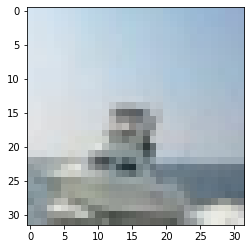

In [ ]:
plt.imshow(np.transpose(sample_image.numpy(), (1, 2, 0)))
plt.show()

In [ ]:
len(train_set), len(test_set)

(50000, 10000)

In [ ]:
sample_batch = next(iter(train_loader))
sample_batch = sample_batch[0].to(device), sample_batch[1].to(device)
sample_batch[0].shape, sample_batch[1].shape

(torch.Size([64, 3, 32, 32]), torch.Size([64]))

## Model

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
      nn.MaxPool2d(kernel_size=2),
      nn.ReLU(),
    )
    self.lin = nn.Sequential(
        nn.Linear(in_features=32*15*15, out_features=600),
        nn.ReLU(),
        nn.Linear(in_features=600, out_features=120),
        nn.ReLU(),
        nn.Linear(in_features=120, out_features=10)
    )
    self.softmax = nn.LogSoftmax(dim=1)
  def forward(self, x):
    out = self.conv(x)
    out = out.view(out.size(0), -1)
    out = self.lin(out)
    out = self.softmax(out)
    return out
model = CNN()
model.to(device)

CNN(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (lin): Sequential(
    (0): Linear(in_features=7200, out_features=600, bias=True)
    (1): ReLU()
    (2): Linear(in_features=600, out_features=120, bias=True)
    (3): ReLU()
    (4): Linear(in_features=120, out_features=10, bias=True)
  )
  (softmax): LogSoftmax(dim=1)
)

In [ ]:
# hyperparameters
NUM_EPOCHS = 100

In [ ]:
error = nn.NLLLoss()
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01, eps=1e-8)

## Training

In [ ]:
DISPLAY_INTERVAL = 1
train_loss, test_loss = [], [] # denotes the mean loss over all samples
train_acc, test_acc = [], []
for epoch in range(1, NUM_EPOCHS + 1):
  total_loss = 0
  correct, total = 0, 0
  for images, labels in tqdm(train_loader):
    # forward + backward + step
    optimizer.zero_grad()
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    loss = error(outputs, labels)
    total_loss += loss.item() * len(outputs)
    loss.backward()
    optimizer.step()
    # accuracy calculation
    correct += (torch.argmax(outputs, dim=1) == labels).sum()
    total += len(labels)
  train_loss.append(total_loss / total)
  train_acc.append(correct / total)
  # testing loss
  with torch.no_grad():
    predicted = model(test_X)
    loss = error(predicted, test_Y)
    test_loss.append(loss.item())
    test_acc.append((torch.argmax(predicted, dim=1) == test_Y).sum() / len(test_Y))

  if epoch % DISPLAY_INTERVAL == 0:
      print(f'Performace at epoch {epoch}')
      print(f'Train Loss: {train_loss[-1]:.5f} ; Train Acc: {train_acc[-1]:.5f}')
      print(f'Test Loss: {test_loss[-1]:.5f} ; Test Acc: {test_acc[-1]:.5f}')
      print('==============')

100%|██████████| 391/391 [00:06<00:00, 60.54it/s]


Performace at epoch 1
Train Loss: 1.93641 ; Train Acc: 0.33148
Test Loss: 1.62354 ; Test Acc: 0.41201


100%|██████████| 391/391 [00:06<00:00, 60.80it/s]


Performace at epoch 2
Train Loss: 1.49577 ; Train Acc: 0.45820
Test Loss: 1.44872 ; Test Acc: 0.46817


100%|██████████| 391/391 [00:06<00:00, 59.96it/s]


Performace at epoch 3
Train Loss: 1.37087 ; Train Acc: 0.50616
Test Loss: 1.35918 ; Test Acc: 0.51441


100%|██████████| 391/391 [00:06<00:00, 60.47it/s]


Performace at epoch 4
Train Loss: 1.29125 ; Train Acc: 0.53864
Test Loss: 1.32807 ; Test Acc: 0.52072


100%|██████████| 391/391 [00:06<00:00, 61.08it/s]


Performace at epoch 5
Train Loss: 1.23263 ; Train Acc: 0.55796
Test Loss: 1.26546 ; Test Acc: 0.54174


100%|██████████| 391/391 [00:06<00:00, 61.71it/s]


Performace at epoch 6
Train Loss: 1.18286 ; Train Acc: 0.57720
Test Loss: 1.25954 ; Test Acc: 0.55075


100%|██████████| 391/391 [00:06<00:00, 60.04it/s]


Performace at epoch 7
Train Loss: 1.14150 ; Train Acc: 0.59084
Test Loss: 1.22722 ; Test Acc: 0.56306


100%|██████████| 391/391 [00:06<00:00, 61.01it/s]


Performace at epoch 8
Train Loss: 1.10362 ; Train Acc: 0.60624
Test Loss: 1.23755 ; Test Acc: 0.55075


100%|██████████| 391/391 [00:06<00:00, 61.10it/s]


Performace at epoch 9
Train Loss: 1.07097 ; Train Acc: 0.62156
Test Loss: 1.20016 ; Test Acc: 0.57538


100%|██████████| 391/391 [00:06<00:00, 61.60it/s]


Performace at epoch 10
Train Loss: 1.03976 ; Train Acc: 0.63208
Test Loss: 1.20577 ; Test Acc: 0.56907


100%|██████████| 391/391 [00:06<00:00, 61.65it/s]


Performace at epoch 11
Train Loss: 1.00771 ; Train Acc: 0.64640
Test Loss: 1.16922 ; Test Acc: 0.57838


100%|██████████| 391/391 [00:06<00:00, 61.01it/s]


Performace at epoch 12
Train Loss: 0.98050 ; Train Acc: 0.65524
Test Loss: 1.15963 ; Test Acc: 0.59369


100%|██████████| 391/391 [00:06<00:00, 61.30it/s]


Performace at epoch 13
Train Loss: 0.95496 ; Train Acc: 0.66428
Test Loss: 1.15059 ; Test Acc: 0.59580


100%|██████████| 391/391 [00:06<00:00, 60.29it/s]


Performace at epoch 14
Train Loss: 0.93028 ; Train Acc: 0.67304
Test Loss: 1.14274 ; Test Acc: 0.60330


100%|██████████| 391/391 [00:06<00:00, 60.69it/s]


Performace at epoch 15
Train Loss: 0.90817 ; Train Acc: 0.68128
Test Loss: 1.13326 ; Test Acc: 0.59520


100%|██████████| 391/391 [00:06<00:00, 61.59it/s]


Performace at epoch 16
Train Loss: 0.88344 ; Train Acc: 0.69344
Test Loss: 1.16660 ; Test Acc: 0.59129


100%|██████████| 391/391 [00:06<00:00, 59.96it/s]


Performace at epoch 17
Train Loss: 0.86147 ; Train Acc: 0.70040
Test Loss: 1.13141 ; Test Acc: 0.59940


100%|██████████| 391/391 [00:06<00:00, 61.03it/s]


Performace at epoch 18
Train Loss: 0.83974 ; Train Acc: 0.70856
Test Loss: 1.13943 ; Test Acc: 0.60150


100%|██████████| 391/391 [00:06<00:00, 60.60it/s]


Performace at epoch 19
Train Loss: 0.81831 ; Train Acc: 0.71572
Test Loss: 1.13303 ; Test Acc: 0.59580


100%|██████████| 391/391 [00:06<00:00, 60.49it/s]


Performace at epoch 20
Train Loss: 0.79906 ; Train Acc: 0.72188
Test Loss: 1.14138 ; Test Acc: 0.60420


100%|██████████| 391/391 [00:06<00:00, 60.59it/s]


Performace at epoch 21
Train Loss: 0.77790 ; Train Acc: 0.73056
Test Loss: 1.14230 ; Test Acc: 0.60751


100%|██████████| 391/391 [00:06<00:00, 60.21it/s]


Performace at epoch 22
Train Loss: 0.76154 ; Train Acc: 0.73700
Test Loss: 1.13135 ; Test Acc: 0.60781


100%|██████████| 391/391 [00:06<00:00, 61.23it/s]


Performace at epoch 23
Train Loss: 0.74206 ; Train Acc: 0.74632
Test Loss: 1.12067 ; Test Acc: 0.61381


100%|██████████| 391/391 [00:06<00:00, 60.40it/s]


Performace at epoch 24
Train Loss: 0.72417 ; Train Acc: 0.75000
Test Loss: 1.14495 ; Test Acc: 0.60511


100%|██████████| 391/391 [00:06<00:00, 61.10it/s]


Performace at epoch 25
Train Loss: 0.70597 ; Train Acc: 0.75608
Test Loss: 1.13217 ; Test Acc: 0.61291


100%|██████████| 391/391 [00:06<00:00, 60.42it/s]


Performace at epoch 26
Train Loss: 0.68842 ; Train Acc: 0.76468
Test Loss: 1.14615 ; Test Acc: 0.61171


100%|██████████| 391/391 [00:06<00:00, 59.69it/s]


Performace at epoch 27
Train Loss: 0.67365 ; Train Acc: 0.76836
Test Loss: 1.14010 ; Test Acc: 0.61622


100%|██████████| 391/391 [00:06<00:00, 60.78it/s]


Performace at epoch 28
Train Loss: 0.65459 ; Train Acc: 0.77772
Test Loss: 1.16133 ; Test Acc: 0.61291


100%|██████████| 391/391 [00:06<00:00, 59.82it/s]


Performace at epoch 29
Train Loss: 0.63886 ; Train Acc: 0.78144
Test Loss: 1.13785 ; Test Acc: 0.61832


100%|██████████| 391/391 [00:06<00:00, 60.13it/s]


Performace at epoch 30
Train Loss: 0.62281 ; Train Acc: 0.78920
Test Loss: 1.17108 ; Test Acc: 0.60841


100%|██████████| 391/391 [00:06<00:00, 60.55it/s]


Performace at epoch 31
Train Loss: 0.60823 ; Train Acc: 0.79444
Test Loss: 1.16374 ; Test Acc: 0.61862


100%|██████████| 391/391 [00:06<00:00, 60.93it/s]


Performace at epoch 32
Train Loss: 0.59293 ; Train Acc: 0.79968
Test Loss: 1.15865 ; Test Acc: 0.61502


100%|██████████| 391/391 [00:06<00:00, 60.59it/s]


Performace at epoch 33
Train Loss: 0.57891 ; Train Acc: 0.80584
Test Loss: 1.16466 ; Test Acc: 0.61922


100%|██████████| 391/391 [00:06<00:00, 60.50it/s]


Performace at epoch 34
Train Loss: 0.56575 ; Train Acc: 0.80944
Test Loss: 1.16247 ; Test Acc: 0.62042


100%|██████████| 391/391 [00:06<00:00, 60.79it/s]


Performace at epoch 35
Train Loss: 0.54930 ; Train Acc: 0.81660
Test Loss: 1.17589 ; Test Acc: 0.61712


100%|██████████| 391/391 [00:06<00:00, 61.03it/s]


Performace at epoch 36
Train Loss: 0.53594 ; Train Acc: 0.82260
Test Loss: 1.18644 ; Test Acc: 0.61922


100%|██████████| 391/391 [00:06<00:00, 61.24it/s]


Performace at epoch 37
Train Loss: 0.52195 ; Train Acc: 0.82912
Test Loss: 1.17136 ; Test Acc: 0.61772


100%|██████████| 391/391 [00:06<00:00, 61.57it/s]


Performace at epoch 38
Train Loss: 0.50990 ; Train Acc: 0.83328
Test Loss: 1.18722 ; Test Acc: 0.61922


100%|██████████| 391/391 [00:06<00:00, 60.53it/s]


Performace at epoch 39
Train Loss: 0.49574 ; Train Acc: 0.83736
Test Loss: 1.22608 ; Test Acc: 0.61351


100%|██████████| 391/391 [00:06<00:00, 59.37it/s]


Performace at epoch 40
Train Loss: 0.48317 ; Train Acc: 0.84336
Test Loss: 1.19878 ; Test Acc: 0.61562


100%|██████████| 391/391 [00:06<00:00, 61.22it/s]


Performace at epoch 41
Train Loss: 0.47122 ; Train Acc: 0.84632
Test Loss: 1.22272 ; Test Acc: 0.61682


100%|██████████| 391/391 [00:06<00:00, 59.21it/s]


Performace at epoch 42
Train Loss: 0.45903 ; Train Acc: 0.85220
Test Loss: 1.22637 ; Test Acc: 0.61892


100%|██████████| 391/391 [00:06<00:00, 60.22it/s]


Performace at epoch 43
Train Loss: 0.44797 ; Train Acc: 0.85576
Test Loss: 1.22819 ; Test Acc: 0.61802


100%|██████████| 391/391 [00:06<00:00, 59.02it/s]


Performace at epoch 44
Train Loss: 0.43662 ; Train Acc: 0.86072
Test Loss: 1.23396 ; Test Acc: 0.61562


100%|██████████| 391/391 [00:06<00:00, 59.49it/s]


Performace at epoch 45
Train Loss: 0.42512 ; Train Acc: 0.86424
Test Loss: 1.23818 ; Test Acc: 0.62072


100%|██████████| 391/391 [00:06<00:00, 59.68it/s]


Performace at epoch 46
Train Loss: 0.41460 ; Train Acc: 0.86952
Test Loss: 1.24935 ; Test Acc: 0.61532


100%|██████████| 391/391 [00:06<00:00, 60.36it/s]


Performace at epoch 47
Train Loss: 0.40202 ; Train Acc: 0.87516
Test Loss: 1.26734 ; Test Acc: 0.61532


100%|██████████| 391/391 [00:06<00:00, 59.94it/s]


Performace at epoch 48
Train Loss: 0.39326 ; Train Acc: 0.87968
Test Loss: 1.28371 ; Test Acc: 0.61381


100%|██████████| 391/391 [00:06<00:00, 60.01it/s]


Performace at epoch 49
Train Loss: 0.38318 ; Train Acc: 0.88380
Test Loss: 1.28558 ; Test Acc: 0.61231


100%|██████████| 391/391 [00:06<00:00, 59.43it/s]


Performace at epoch 50
Train Loss: 0.37255 ; Train Acc: 0.88544
Test Loss: 1.30556 ; Test Acc: 0.61201


100%|██████████| 391/391 [00:06<00:00, 60.44it/s]


Performace at epoch 51
Train Loss: 0.36191 ; Train Acc: 0.89112
Test Loss: 1.29515 ; Test Acc: 0.61201


100%|██████████| 391/391 [00:06<00:00, 60.52it/s]


Performace at epoch 52
Train Loss: 0.35235 ; Train Acc: 0.89512
Test Loss: 1.30988 ; Test Acc: 0.61261


100%|██████████| 391/391 [00:06<00:00, 60.94it/s]


Performace at epoch 53
Train Loss: 0.34304 ; Train Acc: 0.89728
Test Loss: 1.31384 ; Test Acc: 0.61201


100%|██████████| 391/391 [00:06<00:00, 59.50it/s]


Performace at epoch 54
Train Loss: 0.33387 ; Train Acc: 0.90392
Test Loss: 1.31724 ; Test Acc: 0.61231


100%|██████████| 391/391 [00:06<00:00, 59.43it/s]


Performace at epoch 55
Train Loss: 0.32429 ; Train Acc: 0.90684
Test Loss: 1.32081 ; Test Acc: 0.61141


100%|██████████| 391/391 [00:06<00:00, 60.70it/s]


Performace at epoch 56
Train Loss: 0.31524 ; Train Acc: 0.90968
Test Loss: 1.34935 ; Test Acc: 0.61441


100%|██████████| 391/391 [00:06<00:00, 59.00it/s]


Performace at epoch 57
Train Loss: 0.30740 ; Train Acc: 0.91232
Test Loss: 1.37379 ; Test Acc: 0.60901


100%|██████████| 391/391 [00:06<00:00, 60.52it/s]


Performace at epoch 58
Train Loss: 0.29747 ; Train Acc: 0.91648
Test Loss: 1.37040 ; Test Acc: 0.61021


100%|██████████| 391/391 [00:06<00:00, 60.21it/s]


Performace at epoch 59
Train Loss: 0.28970 ; Train Acc: 0.92012
Test Loss: 1.36451 ; Test Acc: 0.61231


100%|██████████| 391/391 [00:06<00:00, 57.95it/s]


Performace at epoch 60
Train Loss: 0.28125 ; Train Acc: 0.92440
Test Loss: 1.37877 ; Test Acc: 0.61291


100%|██████████| 391/391 [00:06<00:00, 59.50it/s]


Performace at epoch 61
Train Loss: 0.27459 ; Train Acc: 0.92620
Test Loss: 1.39198 ; Test Acc: 0.60991


100%|██████████| 391/391 [00:06<00:00, 58.70it/s]


Performace at epoch 62
Train Loss: 0.26581 ; Train Acc: 0.92948
Test Loss: 1.39617 ; Test Acc: 0.61502


100%|██████████| 391/391 [00:06<00:00, 59.06it/s]


Performace at epoch 63
Train Loss: 0.25897 ; Train Acc: 0.93208
Test Loss: 1.41384 ; Test Acc: 0.61351


100%|██████████| 391/391 [00:06<00:00, 58.82it/s]


Performace at epoch 64
Train Loss: 0.25086 ; Train Acc: 0.93540
Test Loss: 1.43423 ; Test Acc: 0.60420


100%|██████████| 391/391 [00:06<00:00, 59.15it/s]


Performace at epoch 65
Train Loss: 0.24321 ; Train Acc: 0.93812
Test Loss: 1.44543 ; Test Acc: 0.60961


100%|██████████| 391/391 [00:06<00:00, 59.81it/s]


Performace at epoch 66
Train Loss: 0.23652 ; Train Acc: 0.94088
Test Loss: 1.45667 ; Test Acc: 0.60901


100%|██████████| 391/391 [00:06<00:00, 59.57it/s]


Performace at epoch 67
Train Loss: 0.22972 ; Train Acc: 0.94284
Test Loss: 1.44939 ; Test Acc: 0.61261


100%|██████████| 391/391 [00:06<00:00, 59.11it/s]


Performace at epoch 68
Train Loss: 0.22327 ; Train Acc: 0.94572
Test Loss: 1.49380 ; Test Acc: 0.60931


100%|██████████| 391/391 [00:06<00:00, 58.46it/s]


Performace at epoch 69
Train Loss: 0.21655 ; Train Acc: 0.94816
Test Loss: 1.49550 ; Test Acc: 0.60541


100%|██████████| 391/391 [00:06<00:00, 58.99it/s]


Performace at epoch 70
Train Loss: 0.21084 ; Train Acc: 0.95008
Test Loss: 1.48203 ; Test Acc: 0.61201


100%|██████████| 391/391 [00:06<00:00, 60.55it/s]


Performace at epoch 71
Train Loss: 0.20360 ; Train Acc: 0.95196
Test Loss: 1.50020 ; Test Acc: 0.60841


100%|██████████| 391/391 [00:06<00:00, 59.87it/s]


Performace at epoch 72
Train Loss: 0.19754 ; Train Acc: 0.95508
Test Loss: 1.51329 ; Test Acc: 0.60450


100%|██████████| 391/391 [00:06<00:00, 59.37it/s]


Performace at epoch 73
Train Loss: 0.19243 ; Train Acc: 0.95548
Test Loss: 1.52117 ; Test Acc: 0.61141


100%|██████████| 391/391 [00:06<00:00, 59.40it/s]


Performace at epoch 74
Train Loss: 0.18669 ; Train Acc: 0.95896
Test Loss: 1.53388 ; Test Acc: 0.60871


100%|██████████| 391/391 [00:06<00:00, 59.17it/s]


Performace at epoch 75
Train Loss: 0.18150 ; Train Acc: 0.96032
Test Loss: 1.57416 ; Test Acc: 0.60811


100%|██████████| 391/391 [00:06<00:00, 59.18it/s]


Performace at epoch 76
Train Loss: 0.17615 ; Train Acc: 0.96124
Test Loss: 1.55565 ; Test Acc: 0.61231


100%|██████████| 391/391 [00:06<00:00, 58.62it/s]


Performace at epoch 77
Train Loss: 0.17081 ; Train Acc: 0.96388
Test Loss: 1.56287 ; Test Acc: 0.60601


100%|██████████| 391/391 [00:06<00:00, 58.92it/s]


Performace at epoch 78
Train Loss: 0.16558 ; Train Acc: 0.96556
Test Loss: 1.58912 ; Test Acc: 0.61021


100%|██████████| 391/391 [00:06<00:00, 59.07it/s]


Performace at epoch 79
Train Loss: 0.16061 ; Train Acc: 0.96696
Test Loss: 1.57422 ; Test Acc: 0.60841


100%|██████████| 391/391 [00:06<00:00, 57.20it/s]


Performace at epoch 80
Train Loss: 0.15570 ; Train Acc: 0.96936
Test Loss: 1.60125 ; Test Acc: 0.60991


100%|██████████| 391/391 [00:06<00:00, 58.37it/s]


Performace at epoch 81
Train Loss: 0.15142 ; Train Acc: 0.97000
Test Loss: 1.61718 ; Test Acc: 0.60240


100%|██████████| 391/391 [00:06<00:00, 59.73it/s]


Performace at epoch 82
Train Loss: 0.14766 ; Train Acc: 0.97248
Test Loss: 1.61765 ; Test Acc: 0.60390


100%|██████████| 391/391 [00:06<00:00, 58.51it/s]


Performace at epoch 83
Train Loss: 0.14285 ; Train Acc: 0.97348
Test Loss: 1.62474 ; Test Acc: 0.61321


100%|██████████| 391/391 [00:06<00:00, 57.10it/s]


Performace at epoch 84
Train Loss: 0.13830 ; Train Acc: 0.97468
Test Loss: 1.66540 ; Test Acc: 0.60571


100%|██████████| 391/391 [00:06<00:00, 57.32it/s]


Performace at epoch 85
Train Loss: 0.13459 ; Train Acc: 0.97628
Test Loss: 1.65267 ; Test Acc: 0.60661


100%|██████████| 391/391 [00:06<00:00, 59.22it/s]


Performace at epoch 86
Train Loss: 0.13023 ; Train Acc: 0.97744
Test Loss: 1.66367 ; Test Acc: 0.61441


100%|██████████| 391/391 [00:06<00:00, 58.08it/s]


Performace at epoch 87
Train Loss: 0.12642 ; Train Acc: 0.97848
Test Loss: 1.67065 ; Test Acc: 0.60961


100%|██████████| 391/391 [00:06<00:00, 57.48it/s]


Performace at epoch 88
Train Loss: 0.12340 ; Train Acc: 0.97820
Test Loss: 1.69533 ; Test Acc: 0.60541


100%|██████████| 391/391 [00:06<00:00, 56.78it/s]


Performace at epoch 89
Train Loss: 0.11945 ; Train Acc: 0.98064
Test Loss: 1.69284 ; Test Acc: 0.60480


100%|██████████| 391/391 [00:06<00:00, 56.94it/s]


Performace at epoch 90
Train Loss: 0.11567 ; Train Acc: 0.98152
Test Loss: 1.70308 ; Test Acc: 0.60871


100%|██████████| 391/391 [00:06<00:00, 57.79it/s]


Performace at epoch 91
Train Loss: 0.11177 ; Train Acc: 0.98288
Test Loss: 1.74329 ; Test Acc: 0.60180


100%|██████████| 391/391 [00:06<00:00, 56.32it/s]


Performace at epoch 92
Train Loss: 0.10863 ; Train Acc: 0.98404
Test Loss: 1.74296 ; Test Acc: 0.60841


100%|██████████| 391/391 [00:06<00:00, 55.97it/s]


Performace at epoch 93
Train Loss: 0.10557 ; Train Acc: 0.98492
Test Loss: 1.73835 ; Test Acc: 0.61291


100%|██████████| 391/391 [00:06<00:00, 56.37it/s]


Performace at epoch 94
Train Loss: 0.10235 ; Train Acc: 0.98524
Test Loss: 1.74640 ; Test Acc: 0.60811


100%|██████████| 391/391 [00:06<00:00, 58.53it/s]


Performace at epoch 95
Train Loss: 0.09933 ; Train Acc: 0.98620
Test Loss: 1.76032 ; Test Acc: 0.60931


100%|██████████| 391/391 [00:06<00:00, 58.77it/s]


Performace at epoch 96
Train Loss: 0.09622 ; Train Acc: 0.98700
Test Loss: 1.76720 ; Test Acc: 0.60991


100%|██████████| 391/391 [00:06<00:00, 59.07it/s]


Performace at epoch 97
Train Loss: 0.09349 ; Train Acc: 0.98696
Test Loss: 1.80466 ; Test Acc: 0.60661


100%|██████████| 391/391 [00:06<00:00, 59.31it/s]


Performace at epoch 98
Train Loss: 0.09059 ; Train Acc: 0.98796
Test Loss: 1.79740 ; Test Acc: 0.61051


100%|██████████| 391/391 [00:06<00:00, 57.95it/s]


Performace at epoch 99
Train Loss: 0.08802 ; Train Acc: 0.98876
Test Loss: 1.82429 ; Test Acc: 0.60661


100%|██████████| 391/391 [00:06<00:00, 58.73it/s]

Performace at epoch 100
Train Loss: 0.08506 ; Train Acc: 0.98956
Test Loss: 1.80649 ; Test Acc: 0.60721


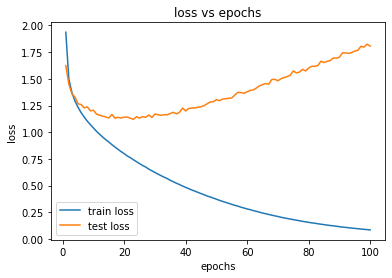

In [ ]:
# plot loss
plt.plot(range(1, len(train_loss) + 1), train_loss, label='train loss')
plt.plot(range(1, len(test_loss) + 1), test_loss, label='test loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss vs epochs')
plt.legend()
plt.show()

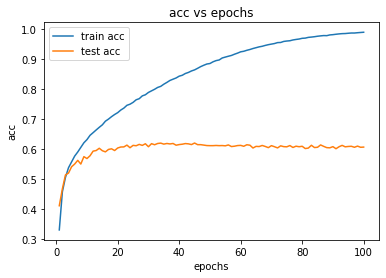

In [ ]:
# plot acc
plt.plot(range(1, NUM_EPOCHS + 1), train_acc, label='train acc')
plt.plot(range(1, NUM_EPOCHS + 1), test_acc, label='test acc')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.title('acc vs epochs')
plt.legend()
plt.show()

## Hyperparameter tuning
- For a set of hyperparameters, various trials with different models are trained based on randomly-sampled or exhaustive hyperparameters upto a certain number of epochs (dependent on lr). Finally the best set of hyperparameters are chosen which correspond to the minimum testing loss after training.

In [ ]:
import decimal

In [ ]:
HYPERPARAMS = {
    'lr': [0.1, 0.05, 0.01, 0.005, 0.001, 0.0001],
    'eps': [1e-7, 1e-8, 1e-9],
    'weight_decay': [1e-4, 1e-5, 1e-6]
}
TRIALS = 10

def get_epochs(lr):
    '''
    returns number of epochs for a given learning rate while tuning
    '''
    d = decimal.Decimal(str(lr))
    pow = d.as_tuple().exponent
    if pow >= -1:
        return 10
    elif pow >= -2:
        return 15
    elif pow >= -3:
        return 20
    else:
        return 25

In [ ]:
best_params, min_loss = None, np.inf
for t in range(TRIALS):
    print(f'\n> Starting trial {t+1}')
    ## choose a set of hyperparameters
    chosen = {}
    for h in HYPERPARAMS:
        chosen[h] = np.random.choice(HYPERPARAMS[h])
    print(f'Chosen hyperparams: {chosen}')
    print()
    ## model, loss & optimizer
    model = CNN()
    model.to(device)
    error = nn.NLLLoss()
    optimizer = torch.optim.Adagrad(model.parameters(), lr=chosen['lr'], eps=chosen['eps'], weight_decay=chosen['weight_decay'])
    ## training
    EPOCHS_TEST = get_epochs(chosen['lr'])
    for epoch in range(1, EPOCHS_TEST + 1):
        total_loss = 0; total = 0
        for images, labels in tqdm(train_loader):
            # forward + backward + step
            optimizer.zero_grad()
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = error(outputs, labels)
            total_loss += loss.item() * len(outputs)
            loss.backward() 
            optimizer.step() 
            total += len(labels)
        total_loss /= total
        print(f'Training loss at epoch {epoch}: {total_loss:.5f}')
    ## calculate testing loss
    with torch.no_grad():
        predicted = model(test_X)
        testing_loss = error(predicted, test_Y).item()
    print(f'* Testing loss: {testing_loss:.5f}')
    ## check final total loss
    if testing_loss < min_loss:
        min_loss = testing_loss
        best_params = chosen
        print()
        print(f'* Best params updated!: {best_params}')
    print('==============')


> Starting trial 1
Chosen hyperparams: {'lr': 0.0001, 'eps': 1e-09, 'weight_decay': 1e-05}



100%|██████████| 391/391 [00:06<00:00, 58.63it/s]


Training loss at epoch 1: 2.21262


100%|██████████| 391/391 [00:06<00:00, 58.66it/s]


Training loss at epoch 2: 2.10217


100%|██████████| 391/391 [00:06<00:00, 58.90it/s]


Training loss at epoch 3: 2.03264


100%|██████████| 391/391 [00:06<00:00, 58.75it/s]


Training loss at epoch 4: 1.98504


100%|██████████| 391/391 [00:06<00:00, 59.21it/s]


Training loss at epoch 5: 1.95064


100%|██████████| 391/391 [00:06<00:00, 59.13it/s]


Training loss at epoch 6: 1.92458


100%|██████████| 391/391 [00:06<00:00, 58.77it/s]


Training loss at epoch 7: 1.90406


100%|██████████| 391/391 [00:06<00:00, 58.44it/s]


Training loss at epoch 8: 1.88727


100%|██████████| 391/391 [00:06<00:00, 58.31it/s]


Training loss at epoch 9: 1.87312


100%|██████████| 391/391 [00:06<00:00, 58.29it/s]


Training loss at epoch 10: 1.86034


100%|██████████| 391/391 [00:06<00:00, 59.32it/s]


Training loss at epoch 11: 1.84946


100%|██████████| 391/391 [00:06<00:00, 59.48it/s]


Training loss at epoch 12: 1.83947


100%|██████████| 391/391 [00:06<00:00, 57.45it/s]


Training loss at epoch 13: 1.82998


100%|██████████| 391/391 [00:06<00:00, 58.45it/s]


Training loss at epoch 14: 1.82120


100%|██████████| 391/391 [00:06<00:00, 58.68it/s]


Training loss at epoch 15: 1.81242


100%|██████████| 391/391 [00:06<00:00, 59.03it/s]


Training loss at epoch 16: 1.80409


100%|██████████| 391/391 [00:06<00:00, 57.24it/s]


Training loss at epoch 17: 1.79666


100%|██████████| 391/391 [00:06<00:00, 58.87it/s]


Training loss at epoch 18: 1.78945


100%|██████████| 391/391 [00:06<00:00, 58.79it/s]


Training loss at epoch 19: 1.78315


100%|██████████| 391/391 [00:06<00:00, 58.81it/s]


Training loss at epoch 20: 1.77718


100%|██████████| 391/391 [00:06<00:00, 59.03it/s]


Training loss at epoch 21: 1.77161


100%|██████████| 391/391 [00:06<00:00, 59.19it/s]


Training loss at epoch 22: 1.76640


100%|██████████| 391/391 [00:06<00:00, 57.87it/s]


Training loss at epoch 23: 1.76152


100%|██████████| 391/391 [00:06<00:00, 59.26it/s]


Training loss at epoch 24: 1.75671


100%|██████████| 391/391 [00:06<00:00, 58.85it/s]


Training loss at epoch 25: 1.75193
* Testing loss: 1.76087

* Best params updated!: {'lr': 0.0001, 'eps': 1e-09, 'weight_decay': 1e-05}

> Starting trial 2
Chosen hyperparams: {'lr': 0.05, 'eps': 1e-08, 'weight_decay': 0.0001}



100%|██████████| 391/391 [00:06<00:00, 56.08it/s]


Training loss at epoch 1: 7.66732


100%|██████████| 391/391 [00:06<00:00, 57.85it/s]


Training loss at epoch 2: 1.60156


100%|██████████| 391/391 [00:06<00:00, 58.00it/s]


Training loss at epoch 3: 1.46617


100%|██████████| 391/391 [00:06<00:00, 59.52it/s]


Training loss at epoch 4: 1.36799


100%|██████████| 391/391 [00:06<00:00, 59.50it/s]


Training loss at epoch 5: 1.29125


100%|██████████| 391/391 [00:06<00:00, 57.46it/s]


Training loss at epoch 6: 1.22500


100%|██████████| 391/391 [00:06<00:00, 57.79it/s]


Training loss at epoch 7: 1.16451


100%|██████████| 391/391 [00:06<00:00, 56.83it/s]


Training loss at epoch 8: 1.11457


100%|██████████| 391/391 [00:06<00:00, 57.14it/s]


Training loss at epoch 9: 1.06897


100%|██████████| 391/391 [00:06<00:00, 58.11it/s]


Training loss at epoch 10: 1.02124


100%|██████████| 391/391 [00:06<00:00, 57.77it/s]


Training loss at epoch 11: 0.97926


100%|██████████| 391/391 [00:06<00:00, 57.34it/s]


Training loss at epoch 12: 0.94474


100%|██████████| 391/391 [00:06<00:00, 57.36it/s]


Training loss at epoch 13: 0.90331


100%|██████████| 391/391 [00:06<00:00, 57.37it/s]


Training loss at epoch 14: 0.86420


100%|██████████| 391/391 [00:06<00:00, 58.02it/s]


Training loss at epoch 15: 0.82439
* Testing loss: 1.20504

* Best params updated!: {'lr': 0.05, 'eps': 1e-08, 'weight_decay': 0.0001}

> Starting trial 3
Chosen hyperparams: {'lr': 0.05, 'eps': 1e-08, 'weight_decay': 0.0001}



100%|██████████| 391/391 [00:06<00:00, 58.20it/s]


Training loss at epoch 1: 5.86543


100%|██████████| 391/391 [00:06<00:00, 58.06it/s]


Training loss at epoch 2: 1.71213


100%|██████████| 391/391 [00:06<00:00, 56.82it/s]


Training loss at epoch 3: 1.55677


100%|██████████| 391/391 [00:06<00:00, 57.57it/s]


Training loss at epoch 4: 1.43481


100%|██████████| 391/391 [00:06<00:00, 57.58it/s]


Training loss at epoch 5: 1.34532


100%|██████████| 391/391 [00:06<00:00, 57.63it/s]


Training loss at epoch 6: 1.28123


100%|██████████| 391/391 [00:06<00:00, 59.10it/s]


Training loss at epoch 7: 1.22128


100%|██████████| 391/391 [00:06<00:00, 58.53it/s]


Training loss at epoch 8: 1.17746


100%|██████████| 391/391 [00:06<00:00, 58.15it/s]


Training loss at epoch 9: 1.13221


100%|██████████| 391/391 [00:06<00:00, 57.41it/s]


Training loss at epoch 10: 1.09384


100%|██████████| 391/391 [00:06<00:00, 57.10it/s]


Training loss at epoch 11: 1.05448


100%|██████████| 391/391 [00:06<00:00, 56.68it/s]


Training loss at epoch 12: 1.01743


100%|██████████| 391/391 [00:06<00:00, 57.13it/s]


Training loss at epoch 13: 0.98190


100%|██████████| 391/391 [00:06<00:00, 59.31it/s]


Training loss at epoch 14: 0.95342


100%|██████████| 391/391 [00:06<00:00, 56.23it/s]


Training loss at epoch 15: 0.91989
* Testing loss: 1.20803

> Starting trial 4
Chosen hyperparams: {'lr': 0.0001, 'eps': 1e-09, 'weight_decay': 0.0001}



100%|██████████| 391/391 [00:07<00:00, 54.71it/s]


Training loss at epoch 1: 2.22414


100%|██████████| 391/391 [00:07<00:00, 54.24it/s]


Training loss at epoch 2: 2.12515


100%|██████████| 391/391 [00:06<00:00, 56.21it/s]


Training loss at epoch 3: 2.05223


100%|██████████| 391/391 [00:06<00:00, 56.71it/s]


Training loss at epoch 4: 2.00023


100%|██████████| 391/391 [00:06<00:00, 56.45it/s]


Training loss at epoch 5: 1.96310


100%|██████████| 391/391 [00:07<00:00, 55.51it/s]


Training loss at epoch 6: 1.93489


100%|██████████| 391/391 [00:07<00:00, 55.26it/s]


Training loss at epoch 7: 1.91272


100%|██████████| 391/391 [00:07<00:00, 55.53it/s]


Training loss at epoch 8: 1.89446


100%|██████████| 391/391 [00:07<00:00, 54.45it/s]


Training loss at epoch 9: 1.87924


100%|██████████| 391/391 [00:07<00:00, 55.48it/s]


Training loss at epoch 10: 1.86553


100%|██████████| 391/391 [00:06<00:00, 56.47it/s]


Training loss at epoch 11: 1.85401


100%|██████████| 391/391 [00:07<00:00, 55.55it/s]


Training loss at epoch 12: 1.84333


100%|██████████| 391/391 [00:07<00:00, 54.46it/s]


Training loss at epoch 13: 1.83382


100%|██████████| 391/391 [00:07<00:00, 54.88it/s]


Training loss at epoch 14: 1.82503


100%|██████████| 391/391 [00:07<00:00, 55.72it/s]


Training loss at epoch 15: 1.81718


100%|██████████| 391/391 [00:07<00:00, 55.03it/s]


Training loss at epoch 16: 1.80965


100%|██████████| 391/391 [00:07<00:00, 55.33it/s]


Training loss at epoch 17: 1.80275


100%|██████████| 391/391 [00:06<00:00, 57.42it/s]


Training loss at epoch 18: 1.79639


100%|██████████| 391/391 [00:06<00:00, 56.56it/s]


Training loss at epoch 19: 1.79057


100%|██████████| 391/391 [00:06<00:00, 57.95it/s]


Training loss at epoch 20: 1.78498


100%|██████████| 391/391 [00:06<00:00, 58.63it/s]


Training loss at epoch 21: 1.77976


100%|██████████| 391/391 [00:06<00:00, 58.27it/s]


Training loss at epoch 22: 1.77468


100%|██████████| 391/391 [00:06<00:00, 57.36it/s]


Training loss at epoch 23: 1.76972


100%|██████████| 391/391 [00:07<00:00, 54.84it/s]


Training loss at epoch 24: 1.76530


100%|██████████| 391/391 [00:06<00:00, 56.76it/s]


Training loss at epoch 25: 1.76093
* Testing loss: 1.76774

> Starting trial 5
Chosen hyperparams: {'lr': 0.01, 'eps': 1e-08, 'weight_decay': 1e-06}



100%|██████████| 391/391 [00:06<00:00, 57.65it/s]


Training loss at epoch 1: 1.84810


100%|██████████| 391/391 [00:06<00:00, 58.13it/s]


Training loss at epoch 2: 1.45456


100%|██████████| 391/391 [00:06<00:00, 57.39it/s]


Training loss at epoch 3: 1.32333


100%|██████████| 391/391 [00:06<00:00, 58.31it/s]


Training loss at epoch 4: 1.23811


100%|██████████| 391/391 [00:06<00:00, 58.03it/s]


Training loss at epoch 5: 1.17951


100%|██████████| 391/391 [00:06<00:00, 56.20it/s]


Training loss at epoch 6: 1.12989


100%|██████████| 391/391 [00:06<00:00, 55.89it/s]


Training loss at epoch 7: 1.08851


100%|██████████| 391/391 [00:06<00:00, 55.90it/s]


Training loss at epoch 8: 1.04745


100%|██████████| 391/391 [00:06<00:00, 56.59it/s]


Training loss at epoch 9: 1.01160


100%|██████████| 391/391 [00:06<00:00, 56.69it/s]


Training loss at epoch 10: 0.97876


100%|██████████| 391/391 [00:06<00:00, 56.34it/s]


Training loss at epoch 11: 0.94718


100%|██████████| 391/391 [00:06<00:00, 56.52it/s]


Training loss at epoch 12: 0.91640


100%|██████████| 391/391 [00:06<00:00, 56.46it/s]


Training loss at epoch 13: 0.88419


100%|██████████| 391/391 [00:06<00:00, 57.00it/s]


Training loss at epoch 14: 0.85823


100%|██████████| 391/391 [00:06<00:00, 56.66it/s]


Training loss at epoch 15: 0.83260
* Testing loss: 1.10218

* Best params updated!: {'lr': 0.01, 'eps': 1e-08, 'weight_decay': 1e-06}

> Starting trial 6
Chosen hyperparams: {'lr': 0.01, 'eps': 1e-07, 'weight_decay': 1e-05}



100%|██████████| 391/391 [00:06<00:00, 56.23it/s]


Training loss at epoch 1: 1.82400


100%|██████████| 391/391 [00:06<00:00, 56.85it/s]


Training loss at epoch 2: 1.44822


100%|██████████| 391/391 [00:06<00:00, 55.99it/s]


Training loss at epoch 3: 1.32941


100%|██████████| 391/391 [00:07<00:00, 54.93it/s]


Training loss at epoch 4: 1.25866


100%|██████████| 391/391 [00:07<00:00, 55.04it/s]


Training loss at epoch 5: 1.20628


100%|██████████| 391/391 [00:07<00:00, 55.08it/s]


Training loss at epoch 6: 1.16464


100%|██████████| 391/391 [00:06<00:00, 56.07it/s]


Training loss at epoch 7: 1.12666


100%|██████████| 391/391 [00:07<00:00, 55.04it/s]


Training loss at epoch 8: 1.09511


100%|██████████| 391/391 [00:07<00:00, 54.48it/s]


Training loss at epoch 9: 1.06520


100%|██████████| 391/391 [00:06<00:00, 56.32it/s]


Training loss at epoch 10: 1.03897


100%|██████████| 391/391 [00:06<00:00, 56.95it/s]


Training loss at epoch 11: 1.01322


100%|██████████| 391/391 [00:06<00:00, 58.12it/s]


Training loss at epoch 12: 0.99124


100%|██████████| 391/391 [00:06<00:00, 56.91it/s]


Training loss at epoch 13: 0.97022


100%|██████████| 391/391 [00:06<00:00, 56.89it/s]


Training loss at epoch 14: 0.94710


100%|██████████| 391/391 [00:06<00:00, 57.00it/s]


Training loss at epoch 15: 0.93083
* Testing loss: 1.12517

> Starting trial 7
Chosen hyperparams: {'lr': 0.01, 'eps': 1e-09, 'weight_decay': 0.0001}



100%|██████████| 391/391 [00:06<00:00, 57.91it/s]


Training loss at epoch 1: 1.80796


100%|██████████| 391/391 [00:06<00:00, 57.19it/s]


Training loss at epoch 2: 1.41325


100%|██████████| 391/391 [00:06<00:00, 58.00it/s]


Training loss at epoch 3: 1.29492


100%|██████████| 391/391 [00:06<00:00, 58.22it/s]


Training loss at epoch 4: 1.22151


100%|██████████| 391/391 [00:07<00:00, 55.42it/s]


Training loss at epoch 5: 1.16507


100%|██████████| 391/391 [00:07<00:00, 54.34it/s]


Training loss at epoch 6: 1.11889


100%|██████████| 391/391 [00:07<00:00, 54.63it/s]


Training loss at epoch 7: 1.07685


100%|██████████| 391/391 [00:06<00:00, 55.92it/s]


Training loss at epoch 8: 1.04206


100%|██████████| 391/391 [00:06<00:00, 58.96it/s]


Training loss at epoch 9: 1.00951


100%|██████████| 391/391 [00:07<00:00, 55.77it/s]


Training loss at epoch 10: 0.97969


100%|██████████| 391/391 [00:07<00:00, 54.23it/s]


Training loss at epoch 11: 0.95347


100%|██████████| 391/391 [00:07<00:00, 55.02it/s]


Training loss at epoch 12: 0.92666


100%|██████████| 391/391 [00:07<00:00, 55.13it/s]


Training loss at epoch 13: 0.89936


100%|██████████| 391/391 [00:07<00:00, 54.58it/s]


Training loss at epoch 14: 0.87525


100%|██████████| 391/391 [00:07<00:00, 55.64it/s]


Training loss at epoch 15: 0.85463
* Testing loss: 1.09173

* Best params updated!: {'lr': 0.01, 'eps': 1e-09, 'weight_decay': 0.0001}

> Starting trial 8
Chosen hyperparams: {'lr': 0.05, 'eps': 1e-08, 'weight_decay': 0.0001}



100%|██████████| 391/391 [00:07<00:00, 54.86it/s]


Training loss at epoch 1: 4.66796


100%|██████████| 391/391 [00:07<00:00, 55.62it/s]


Training loss at epoch 2: 1.53402


100%|██████████| 391/391 [00:06<00:00, 55.89it/s]


Training loss at epoch 3: 1.39040


100%|██████████| 391/391 [00:07<00:00, 55.66it/s]


Training loss at epoch 4: 1.29106


100%|██████████| 391/391 [00:06<00:00, 56.07it/s]


Training loss at epoch 5: 1.21034


100%|██████████| 391/391 [00:07<00:00, 55.77it/s]


Training loss at epoch 6: 1.13480


100%|██████████| 391/391 [00:07<00:00, 55.07it/s]


Training loss at epoch 7: 1.06792


100%|██████████| 391/391 [00:07<00:00, 55.26it/s]


Training loss at epoch 8: 1.01309


100%|██████████| 391/391 [00:07<00:00, 55.20it/s]


Training loss at epoch 9: 0.95267


100%|██████████| 391/391 [00:06<00:00, 56.03it/s]


Training loss at epoch 10: 0.89593


100%|██████████| 391/391 [00:07<00:00, 55.42it/s]


Training loss at epoch 11: 0.83519


100%|██████████| 391/391 [00:07<00:00, 55.34it/s]


Training loss at epoch 12: 0.78830


100%|██████████| 391/391 [00:07<00:00, 54.57it/s]


Training loss at epoch 13: 0.73196


100%|██████████| 391/391 [00:06<00:00, 57.98it/s]


Training loss at epoch 14: 0.67981


100%|██████████| 391/391 [00:06<00:00, 59.26it/s]


Training loss at epoch 15: 0.62733
* Testing loss: 1.28548

> Starting trial 9
Chosen hyperparams: {'lr': 0.05, 'eps': 1e-09, 'weight_decay': 1e-05}



100%|██████████| 391/391 [00:06<00:00, 58.94it/s]


Training loss at epoch 1: 4.63472


100%|██████████| 391/391 [00:07<00:00, 55.05it/s]


Training loss at epoch 2: 1.57252


100%|██████████| 391/391 [00:07<00:00, 55.12it/s]


Training loss at epoch 3: 1.42409


100%|██████████| 391/391 [00:07<00:00, 54.91it/s]


Training loss at epoch 4: 1.31112


100%|██████████| 391/391 [00:07<00:00, 55.30it/s]


Training loss at epoch 5: 1.22577


100%|██████████| 391/391 [00:07<00:00, 54.20it/s]


Training loss at epoch 6: 1.14972


100%|██████████| 391/391 [00:07<00:00, 54.40it/s]


Training loss at epoch 7: 1.08328


100%|██████████| 391/391 [00:07<00:00, 55.04it/s]


Training loss at epoch 8: 1.02323


100%|██████████| 391/391 [00:07<00:00, 54.72it/s]


Training loss at epoch 9: 0.95932


100%|██████████| 391/391 [00:07<00:00, 54.91it/s]


Training loss at epoch 10: 0.90765


100%|██████████| 391/391 [00:07<00:00, 54.44it/s]


Training loss at epoch 11: 0.84742


100%|██████████| 391/391 [00:07<00:00, 54.70it/s]


Training loss at epoch 12: 0.79938


100%|██████████| 391/391 [00:07<00:00, 55.61it/s]


Training loss at epoch 13: 0.74480


100%|██████████| 391/391 [00:07<00:00, 55.17it/s]


Training loss at epoch 14: 0.69880


100%|██████████| 391/391 [00:07<00:00, 54.63it/s]


Training loss at epoch 15: 0.65184
* Testing loss: 1.32769

> Starting trial 10
Chosen hyperparams: {'lr': 0.05, 'eps': 1e-09, 'weight_decay': 1e-05}



100%|██████████| 391/391 [00:07<00:00, 55.47it/s]


Training loss at epoch 1: 4.20956


100%|██████████| 391/391 [00:07<00:00, 55.32it/s]


Training loss at epoch 2: 1.45738


100%|██████████| 391/391 [00:06<00:00, 55.93it/s]


Training loss at epoch 3: 1.30599


100%|██████████| 391/391 [00:07<00:00, 55.83it/s]


Training loss at epoch 4: 1.19700


100%|██████████| 391/391 [00:07<00:00, 55.45it/s]


Training loss at epoch 5: 1.09642


100%|██████████| 391/391 [00:07<00:00, 54.90it/s]


Training loss at epoch 6: 1.01010


100%|██████████| 391/391 [00:07<00:00, 55.43it/s]


Training loss at epoch 7: 0.92838


100%|██████████| 391/391 [00:07<00:00, 55.40it/s]


Training loss at epoch 8: 0.84981


100%|██████████| 391/391 [00:07<00:00, 54.90it/s]


Training loss at epoch 9: 0.76810


100%|██████████| 391/391 [00:06<00:00, 56.54it/s]


Training loss at epoch 10: 0.69594


100%|██████████| 391/391 [00:06<00:00, 59.04it/s]


Training loss at epoch 11: 0.62495


100%|██████████| 391/391 [00:06<00:00, 57.84it/s]


Training loss at epoch 12: 0.55119


100%|██████████| 391/391 [00:06<00:00, 56.33it/s]


Training loss at epoch 13: 0.48903


100%|██████████| 391/391 [00:07<00:00, 55.81it/s]


Training loss at epoch 14: 0.42319


100%|██████████| 391/391 [00:07<00:00, 55.39it/s]

Training loss at epoch 15: 0.36518
* Testing loss: 1.67192


### Training with the best hyperparameters

In [ ]:
best_params

{'eps': 1e-09, 'lr': 0.01, 'weight_decay': 0.0001}

In [ ]:
model = CNN()
model.to(device)
error = nn.NLLLoss()
optimizer = torch.optim.Adagrad(model.parameters(), lr=best_params['lr'], eps=best_params['eps'], weight_decay=best_params['weight_decay'])

In [ ]:
DISPLAY_INTERVAL = 1
train_loss, test_loss = [], [] # denotes the mean loss over all samples
train_acc, test_acc = [], []
for epoch in range(1, NUM_EPOCHS + 1):
  total_loss = 0
  correct, total = 0, 0
  for images, labels in tqdm(train_loader):
    # forward + backward + step
    optimizer.zero_grad()
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    loss = error(outputs, labels)
    total_loss += loss.item() * len(outputs)
    loss.backward()
    optimizer.step()
    # accuracy calculation
    correct += (torch.argmax(outputs, dim=1) == labels).sum()
    total += len(labels)
  train_loss.append(total_loss / total)
  train_acc.append(correct / total)
  # testing loss
  with torch.no_grad():
    predicted = model(test_X)
    loss = error(predicted, test_Y)
    test_loss.append(loss.item())
    test_acc.append((torch.argmax(predicted, dim=1) == test_Y).sum() / len(test_Y))

  if epoch % DISPLAY_INTERVAL == 0:
      print(f'Performace at epoch {epoch}')
      print(f'Train Loss: {train_loss[-1]:.5f} ; Train Acc: {train_acc[-1]:.5f}')
      print(f'Test Loss: {test_loss[-1]:.5f} ; Test Acc: {test_acc[-1]:.5f}')
      print('==============')

100%|██████████| 391/391 [00:06<00:00, 56.30it/s]


Performace at epoch 1
Train Loss: 1.87102 ; Train Acc: 0.32952
Test Loss: 1.61631 ; Test Acc: 0.39550


100%|██████████| 391/391 [00:06<00:00, 56.90it/s]


Performace at epoch 2
Train Loss: 1.47382 ; Train Acc: 0.46864
Test Loss: 1.41693 ; Test Acc: 0.48709


100%|██████████| 391/391 [00:06<00:00, 56.25it/s]


Performace at epoch 3
Train Loss: 1.35463 ; Train Acc: 0.51024
Test Loss: 1.36963 ; Test Acc: 0.51171


100%|██████████| 391/391 [00:06<00:00, 56.93it/s]


Performace at epoch 4
Train Loss: 1.27832 ; Train Acc: 0.54244
Test Loss: 1.30651 ; Test Acc: 0.52823


100%|██████████| 391/391 [00:06<00:00, 56.05it/s]


Performace at epoch 5
Train Loss: 1.22576 ; Train Acc: 0.56180
Test Loss: 1.26706 ; Test Acc: 0.54835


100%|██████████| 391/391 [00:06<00:00, 56.70it/s]


Performace at epoch 6
Train Loss: 1.18445 ; Train Acc: 0.57636
Test Loss: 1.23158 ; Test Acc: 0.55826


100%|██████████| 391/391 [00:06<00:00, 56.26it/s]


Performace at epoch 7
Train Loss: 1.14664 ; Train Acc: 0.58876
Test Loss: 1.24702 ; Test Acc: 0.55285


100%|██████████| 391/391 [00:06<00:00, 56.76it/s]


Performace at epoch 8
Train Loss: 1.11495 ; Train Acc: 0.60404
Test Loss: 1.19980 ; Test Acc: 0.56517


100%|██████████| 391/391 [00:06<00:00, 56.42it/s]


Performace at epoch 9
Train Loss: 1.08355 ; Train Acc: 0.61624
Test Loss: 1.16958 ; Test Acc: 0.57808


100%|██████████| 391/391 [00:06<00:00, 57.37it/s]


Performace at epoch 10
Train Loss: 1.05887 ; Train Acc: 0.62312
Test Loss: 1.18788 ; Test Acc: 0.57628


100%|██████████| 391/391 [00:06<00:00, 59.69it/s]


Performace at epoch 11
Train Loss: 1.03195 ; Train Acc: 0.63636
Test Loss: 1.17316 ; Test Acc: 0.57387


100%|██████████| 391/391 [00:06<00:00, 59.45it/s]


Performace at epoch 12
Train Loss: 1.01109 ; Train Acc: 0.64148
Test Loss: 1.15413 ; Test Acc: 0.58559


100%|██████████| 391/391 [00:06<00:00, 58.45it/s]


Performace at epoch 13
Train Loss: 0.99080 ; Train Acc: 0.65012
Test Loss: 1.13430 ; Test Acc: 0.59520


100%|██████████| 391/391 [00:07<00:00, 55.46it/s]


Performace at epoch 14
Train Loss: 0.97094 ; Train Acc: 0.65848
Test Loss: 1.12283 ; Test Acc: 0.60360


100%|██████████| 391/391 [00:07<00:00, 55.50it/s]


Performace at epoch 15
Train Loss: 0.95031 ; Train Acc: 0.66580
Test Loss: 1.14283 ; Test Acc: 0.59039


100%|██████████| 391/391 [00:07<00:00, 55.63it/s]


Performace at epoch 16
Train Loss: 0.93311 ; Train Acc: 0.67328
Test Loss: 1.13017 ; Test Acc: 0.59820


100%|██████████| 391/391 [00:07<00:00, 55.43it/s]


Performace at epoch 17
Train Loss: 0.91510 ; Train Acc: 0.68176
Test Loss: 1.12648 ; Test Acc: 0.59369


100%|██████████| 391/391 [00:07<00:00, 55.38it/s]


Performace at epoch 18
Train Loss: 0.89703 ; Train Acc: 0.68656
Test Loss: 1.10919 ; Test Acc: 0.60030


100%|██████████| 391/391 [00:07<00:00, 55.20it/s]


Performace at epoch 19
Train Loss: 0.88213 ; Train Acc: 0.69220
Test Loss: 1.11609 ; Test Acc: 0.60120


100%|██████████| 391/391 [00:07<00:00, 54.21it/s]


Performace at epoch 20
Train Loss: 0.86529 ; Train Acc: 0.69900
Test Loss: 1.09524 ; Test Acc: 0.60631


100%|██████████| 391/391 [00:07<00:00, 55.61it/s]


Performace at epoch 21
Train Loss: 0.84789 ; Train Acc: 0.70616
Test Loss: 1.12310 ; Test Acc: 0.59369


100%|██████████| 391/391 [00:07<00:00, 55.13it/s]


Performace at epoch 22
Train Loss: 0.83254 ; Train Acc: 0.71260
Test Loss: 1.09784 ; Test Acc: 0.60871


100%|██████████| 391/391 [00:07<00:00, 54.94it/s]


Performace at epoch 23
Train Loss: 0.81926 ; Train Acc: 0.71600
Test Loss: 1.09260 ; Test Acc: 0.60931


100%|██████████| 391/391 [00:07<00:00, 54.81it/s]


Performace at epoch 24
Train Loss: 0.80272 ; Train Acc: 0.72268
Test Loss: 1.08408 ; Test Acc: 0.61381


100%|██████████| 391/391 [00:07<00:00, 55.35it/s]


Performace at epoch 25
Train Loss: 0.78874 ; Train Acc: 0.72868
Test Loss: 1.09755 ; Test Acc: 0.61201


100%|██████████| 391/391 [00:07<00:00, 55.47it/s]


Performace at epoch 26
Train Loss: 0.77673 ; Train Acc: 0.73128
Test Loss: 1.10158 ; Test Acc: 0.61081


100%|██████████| 391/391 [00:07<00:00, 55.01it/s]


Performace at epoch 27
Train Loss: 0.76245 ; Train Acc: 0.73924
Test Loss: 1.09101 ; Test Acc: 0.61622


100%|██████████| 391/391 [00:07<00:00, 54.71it/s]


Performace at epoch 28
Train Loss: 0.74750 ; Train Acc: 0.74208
Test Loss: 1.10238 ; Test Acc: 0.61652


100%|██████████| 391/391 [00:07<00:00, 55.19it/s]


Performace at epoch 29
Train Loss: 0.73516 ; Train Acc: 0.74788
Test Loss: 1.11104 ; Test Acc: 0.61111


100%|██████████| 391/391 [00:07<00:00, 55.24it/s]


Performace at epoch 30
Train Loss: 0.72159 ; Train Acc: 0.75060
Test Loss: 1.08352 ; Test Acc: 0.62643


100%|██████████| 391/391 [00:06<00:00, 55.89it/s]


Performace at epoch 31
Train Loss: 0.70742 ; Train Acc: 0.75740
Test Loss: 1.09623 ; Test Acc: 0.61982


100%|██████████| 391/391 [00:07<00:00, 55.47it/s]


Performace at epoch 32
Train Loss: 0.69608 ; Train Acc: 0.76052
Test Loss: 1.08375 ; Test Acc: 0.62162


100%|██████████| 391/391 [00:07<00:00, 55.25it/s]


Performace at epoch 33
Train Loss: 0.68383 ; Train Acc: 0.76732
Test Loss: 1.08288 ; Test Acc: 0.62372


100%|██████████| 391/391 [00:07<00:00, 55.63it/s]


Performace at epoch 34
Train Loss: 0.67150 ; Train Acc: 0.77260
Test Loss: 1.08113 ; Test Acc: 0.62192


100%|██████████| 391/391 [00:06<00:00, 56.82it/s]


Performace at epoch 35
Train Loss: 0.65952 ; Train Acc: 0.77556
Test Loss: 1.12294 ; Test Acc: 0.61532


100%|██████████| 391/391 [00:07<00:00, 55.36it/s]


Performace at epoch 36
Train Loss: 0.64707 ; Train Acc: 0.77972
Test Loss: 1.08464 ; Test Acc: 0.62072


100%|██████████| 391/391 [00:07<00:00, 55.31it/s]


Performace at epoch 37
Train Loss: 0.63599 ; Train Acc: 0.78604
Test Loss: 1.11209 ; Test Acc: 0.61772


100%|██████████| 391/391 [00:07<00:00, 55.25it/s]


Performace at epoch 38
Train Loss: 0.62226 ; Train Acc: 0.79172
Test Loss: 1.12032 ; Test Acc: 0.62372


100%|██████████| 391/391 [00:06<00:00, 55.99it/s]


Performace at epoch 39
Train Loss: 0.61316 ; Train Acc: 0.79412
Test Loss: 1.11443 ; Test Acc: 0.61592


100%|██████████| 391/391 [00:06<00:00, 56.59it/s]


Performace at epoch 40
Train Loss: 0.60238 ; Train Acc: 0.79832
Test Loss: 1.13363 ; Test Acc: 0.62072


100%|██████████| 391/391 [00:07<00:00, 54.84it/s]


Performace at epoch 41
Train Loss: 0.58986 ; Train Acc: 0.80472
Test Loss: 1.10769 ; Test Acc: 0.62042


100%|██████████| 391/391 [00:07<00:00, 54.37it/s]


Performace at epoch 42
Train Loss: 0.57868 ; Train Acc: 0.81052
Test Loss: 1.10837 ; Test Acc: 0.62342


100%|██████████| 391/391 [00:07<00:00, 54.02it/s]


Performace at epoch 43
Train Loss: 0.56721 ; Train Acc: 0.81252
Test Loss: 1.12285 ; Test Acc: 0.62192


100%|██████████| 391/391 [00:07<00:00, 54.29it/s]


Performace at epoch 44
Train Loss: 0.55768 ; Train Acc: 0.81588
Test Loss: 1.15957 ; Test Acc: 0.61321


100%|██████████| 391/391 [00:07<00:00, 54.12it/s]


Performace at epoch 45
Train Loss: 0.54850 ; Train Acc: 0.82196
Test Loss: 1.11799 ; Test Acc: 0.62613


100%|██████████| 391/391 [00:07<00:00, 55.15it/s]


Performace at epoch 46
Train Loss: 0.53500 ; Train Acc: 0.82584
Test Loss: 1.13582 ; Test Acc: 0.62192


100%|██████████| 391/391 [00:07<00:00, 54.39it/s]


Performace at epoch 47
Train Loss: 0.52703 ; Train Acc: 0.82992
Test Loss: 1.16564 ; Test Acc: 0.61802


100%|██████████| 391/391 [00:07<00:00, 55.10it/s]


Performace at epoch 48
Train Loss: 0.51701 ; Train Acc: 0.83208
Test Loss: 1.14472 ; Test Acc: 0.61922


100%|██████████| 391/391 [00:07<00:00, 53.90it/s]


Performace at epoch 49
Train Loss: 0.50699 ; Train Acc: 0.83588
Test Loss: 1.13168 ; Test Acc: 0.62673


100%|██████████| 391/391 [00:07<00:00, 55.10it/s]


Performace at epoch 50
Train Loss: 0.49533 ; Train Acc: 0.84072
Test Loss: 1.15741 ; Test Acc: 0.62222


100%|██████████| 391/391 [00:07<00:00, 55.10it/s]


Performace at epoch 51
Train Loss: 0.48811 ; Train Acc: 0.84392
Test Loss: 1.14945 ; Test Acc: 0.62462


100%|██████████| 391/391 [00:07<00:00, 54.02it/s]


Performace at epoch 52
Train Loss: 0.47915 ; Train Acc: 0.84836
Test Loss: 1.16945 ; Test Acc: 0.61532


100%|██████████| 391/391 [00:07<00:00, 55.26it/s]


Performace at epoch 53
Train Loss: 0.47024 ; Train Acc: 0.85120
Test Loss: 1.16495 ; Test Acc: 0.62252


100%|██████████| 391/391 [00:07<00:00, 54.99it/s]


Performace at epoch 54
Train Loss: 0.46058 ; Train Acc: 0.85468
Test Loss: 1.16522 ; Test Acc: 0.62402


100%|██████████| 391/391 [00:07<00:00, 55.00it/s]


Performace at epoch 55
Train Loss: 0.45183 ; Train Acc: 0.85804
Test Loss: 1.18583 ; Test Acc: 0.61862


100%|██████████| 391/391 [00:07<00:00, 54.75it/s]


Performace at epoch 56
Train Loss: 0.44285 ; Train Acc: 0.86264
Test Loss: 1.15590 ; Test Acc: 0.62973


100%|██████████| 391/391 [00:07<00:00, 54.90it/s]


Performace at epoch 57
Train Loss: 0.43452 ; Train Acc: 0.86608
Test Loss: 1.15788 ; Test Acc: 0.62432


100%|██████████| 391/391 [00:07<00:00, 54.80it/s]


Performace at epoch 58
Train Loss: 0.42464 ; Train Acc: 0.86808
Test Loss: 1.16877 ; Test Acc: 0.63033


100%|██████████| 391/391 [00:07<00:00, 54.67it/s]


Performace at epoch 59
Train Loss: 0.41671 ; Train Acc: 0.87360
Test Loss: 1.18880 ; Test Acc: 0.62583


100%|██████████| 391/391 [00:07<00:00, 54.87it/s]


Performace at epoch 60
Train Loss: 0.40811 ; Train Acc: 0.87740
Test Loss: 1.20750 ; Test Acc: 0.61982


100%|██████████| 391/391 [00:07<00:00, 54.15it/s]


Performace at epoch 61
Train Loss: 0.39842 ; Train Acc: 0.88004
Test Loss: 1.20547 ; Test Acc: 0.62402


100%|██████████| 391/391 [00:07<00:00, 53.79it/s]


Performace at epoch 62
Train Loss: 0.39186 ; Train Acc: 0.88308
Test Loss: 1.20171 ; Test Acc: 0.62102


100%|██████████| 391/391 [00:07<00:00, 54.77it/s]


Performace at epoch 63
Train Loss: 0.38409 ; Train Acc: 0.88380
Test Loss: 1.20448 ; Test Acc: 0.62703


100%|██████████| 391/391 [00:07<00:00, 54.86it/s]


Performace at epoch 64
Train Loss: 0.37662 ; Train Acc: 0.88928
Test Loss: 1.20697 ; Test Acc: 0.61982


100%|██████████| 391/391 [00:07<00:00, 54.84it/s]


Performace at epoch 65
Train Loss: 0.36922 ; Train Acc: 0.89216
Test Loss: 1.21858 ; Test Acc: 0.62523


100%|██████████| 391/391 [00:07<00:00, 55.11it/s]


Performace at epoch 66
Train Loss: 0.36205 ; Train Acc: 0.89580
Test Loss: 1.27946 ; Test Acc: 0.61291


100%|██████████| 391/391 [00:07<00:00, 54.88it/s]


Performace at epoch 67
Train Loss: 0.35327 ; Train Acc: 0.89808
Test Loss: 1.25373 ; Test Acc: 0.61862


100%|██████████| 391/391 [00:07<00:00, 54.79it/s]


Performace at epoch 68
Train Loss: 0.34630 ; Train Acc: 0.90160
Test Loss: 1.23980 ; Test Acc: 0.62192


100%|██████████| 391/391 [00:07<00:00, 55.23it/s]


Performace at epoch 69
Train Loss: 0.33764 ; Train Acc: 0.90468
Test Loss: 1.23399 ; Test Acc: 0.62763


100%|██████████| 391/391 [00:07<00:00, 55.01it/s]


Performace at epoch 70
Train Loss: 0.33187 ; Train Acc: 0.90700
Test Loss: 1.23355 ; Test Acc: 0.62523


100%|██████████| 391/391 [00:07<00:00, 55.55it/s]


Performace at epoch 71
Train Loss: 0.32323 ; Train Acc: 0.91068
Test Loss: 1.26565 ; Test Acc: 0.62402


100%|██████████| 391/391 [00:07<00:00, 54.43it/s]


Performace at epoch 72
Train Loss: 0.31757 ; Train Acc: 0.91312
Test Loss: 1.27314 ; Test Acc: 0.62252


100%|██████████| 391/391 [00:06<00:00, 56.13it/s]


Performace at epoch 73
Train Loss: 0.31182 ; Train Acc: 0.91520
Test Loss: 1.30277 ; Test Acc: 0.61381


100%|██████████| 391/391 [00:07<00:00, 54.02it/s]


Performace at epoch 74
Train Loss: 0.30522 ; Train Acc: 0.91724
Test Loss: 1.27121 ; Test Acc: 0.61952


100%|██████████| 391/391 [00:07<00:00, 55.09it/s]


Performace at epoch 75
Train Loss: 0.29768 ; Train Acc: 0.92228
Test Loss: 1.28473 ; Test Acc: 0.61862


100%|██████████| 391/391 [00:07<00:00, 54.35it/s]


Performace at epoch 76
Train Loss: 0.29185 ; Train Acc: 0.92444
Test Loss: 1.28314 ; Test Acc: 0.62462


100%|██████████| 391/391 [00:07<00:00, 54.66it/s]


Performace at epoch 77
Train Loss: 0.28511 ; Train Acc: 0.92688
Test Loss: 1.29351 ; Test Acc: 0.62102


100%|██████████| 391/391 [00:07<00:00, 54.98it/s]


Performace at epoch 78
Train Loss: 0.27895 ; Train Acc: 0.92948
Test Loss: 1.31490 ; Test Acc: 0.61291


100%|██████████| 391/391 [00:07<00:00, 55.02it/s]


Performace at epoch 79
Train Loss: 0.27339 ; Train Acc: 0.93188
Test Loss: 1.30250 ; Test Acc: 0.62462


100%|██████████| 391/391 [00:07<00:00, 54.75it/s]


Performace at epoch 80
Train Loss: 0.26632 ; Train Acc: 0.93388
Test Loss: 1.30715 ; Test Acc: 0.62402


100%|██████████| 391/391 [00:07<00:00, 54.82it/s]


Performace at epoch 81
Train Loss: 0.26039 ; Train Acc: 0.93592
Test Loss: 1.31075 ; Test Acc: 0.62042


100%|██████████| 391/391 [00:07<00:00, 54.80it/s]


Performace at epoch 82
Train Loss: 0.25445 ; Train Acc: 0.93828
Test Loss: 1.31960 ; Test Acc: 0.62733


100%|██████████| 391/391 [00:07<00:00, 54.15it/s]


Performace at epoch 83
Train Loss: 0.25010 ; Train Acc: 0.93984
Test Loss: 1.32315 ; Test Acc: 0.62252


100%|██████████| 391/391 [00:07<00:00, 54.91it/s]


Performace at epoch 84
Train Loss: 0.24435 ; Train Acc: 0.94316
Test Loss: 1.36388 ; Test Acc: 0.61562


100%|██████████| 391/391 [00:07<00:00, 54.51it/s]


Performace at epoch 85
Train Loss: 0.23864 ; Train Acc: 0.94532
Test Loss: 1.34784 ; Test Acc: 0.62312


100%|██████████| 391/391 [00:07<00:00, 54.83it/s]


Performace at epoch 86
Train Loss: 0.23313 ; Train Acc: 0.94708
Test Loss: 1.34071 ; Test Acc: 0.61952


100%|██████████| 391/391 [00:07<00:00, 54.64it/s]


Performace at epoch 87
Train Loss: 0.22829 ; Train Acc: 0.94968
Test Loss: 1.37224 ; Test Acc: 0.61592


100%|██████████| 391/391 [00:07<00:00, 54.34it/s]


Performace at epoch 88
Train Loss: 0.22225 ; Train Acc: 0.95012
Test Loss: 1.37329 ; Test Acc: 0.61892


100%|██████████| 391/391 [00:07<00:00, 54.02it/s]


Performace at epoch 89
Train Loss: 0.21790 ; Train Acc: 0.95296
Test Loss: 1.37236 ; Test Acc: 0.61802


100%|██████████| 391/391 [00:07<00:00, 54.31it/s]


Performace at epoch 90
Train Loss: 0.21339 ; Train Acc: 0.95416
Test Loss: 1.37700 ; Test Acc: 0.62523


100%|██████████| 391/391 [00:07<00:00, 55.09it/s]


Performace at epoch 91
Train Loss: 0.20873 ; Train Acc: 0.95528
Test Loss: 1.38635 ; Test Acc: 0.62132


100%|██████████| 391/391 [00:07<00:00, 54.69it/s]


Performace at epoch 92
Train Loss: 0.20420 ; Train Acc: 0.95844
Test Loss: 1.40622 ; Test Acc: 0.62492


100%|██████████| 391/391 [00:07<00:00, 54.62it/s]


Performace at epoch 93
Train Loss: 0.19788 ; Train Acc: 0.96104
Test Loss: 1.40753 ; Test Acc: 0.61682


100%|██████████| 391/391 [00:07<00:00, 55.45it/s]


Performace at epoch 94
Train Loss: 0.19397 ; Train Acc: 0.96136
Test Loss: 1.40838 ; Test Acc: 0.61772


100%|██████████| 391/391 [00:07<00:00, 54.84it/s]


Performace at epoch 95
Train Loss: 0.19014 ; Train Acc: 0.96352
Test Loss: 1.41818 ; Test Acc: 0.61982


100%|██████████| 391/391 [00:07<00:00, 55.33it/s]


Performace at epoch 96
Train Loss: 0.18543 ; Train Acc: 0.96384
Test Loss: 1.43006 ; Test Acc: 0.62162


100%|██████████| 391/391 [00:07<00:00, 54.24it/s]


Performace at epoch 97
Train Loss: 0.18144 ; Train Acc: 0.96476
Test Loss: 1.43206 ; Test Acc: 0.62192


100%|██████████| 391/391 [00:07<00:00, 54.59it/s]


Performace at epoch 98
Train Loss: 0.17667 ; Train Acc: 0.96732
Test Loss: 1.45041 ; Test Acc: 0.61712


100%|██████████| 391/391 [00:07<00:00, 54.85it/s]


Performace at epoch 99
Train Loss: 0.17298 ; Train Acc: 0.96848
Test Loss: 1.45425 ; Test Acc: 0.62102


100%|██████████| 391/391 [00:07<00:00, 54.41it/s]


Performace at epoch 100
Train Loss: 0.16871 ; Train Acc: 0.97056
Test Loss: 1.46684 ; Test Acc: 0.61742


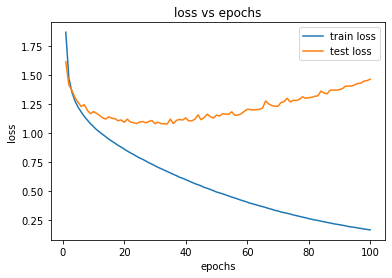

In [ ]:
# plot loss
plt.plot(range(1, len(train_loss) + 1), train_loss, label='train loss')
plt.plot(range(1, len(test_loss) + 1), test_loss, label='test loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss vs epochs')
plt.legend()
plt.show()

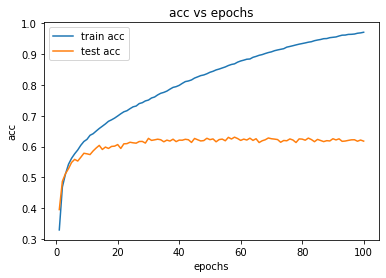

In [ ]:
# plot acc
plt.plot(range(1, NUM_EPOCHS + 1), train_acc, label='train acc')
plt.plot(range(1, NUM_EPOCHS + 1), test_acc, label='test acc')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.title('acc vs epochs')
plt.legend()
plt.show()